In [ ]:
# Training Supervised Model for B-scan slices binary classification

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset,random_split
import torchvision.models as models
import torch.nn.functional as F
from PIL import Image
import os


import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if not torch.backends.mps.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
# FOR Supervised Model
class CustomDataset(Dataset):
    def __init__(self, root_dir, color, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.color = color
        self.data = []

        for label, folder in enumerate(["fovea_no", "fovea_yes"]):
            folder_path = os.path.join(root_dir, folder)
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                if os.path.isfile(img_path):
                    self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert(self.color)

        if self.transform:
            image = self.transform(image)

        return image, label

class DataLoaderModule:
    def __init__(self, root_dir, color, batch_size=32, test_split=0.2):
        self.root_dir = root_dir
        self.color = color
        self.batch_size = batch_size
        self.test_split = test_split

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
            transforms.RandomRotation(degrees=(-10, 10)),  # Random rotation between -10 to 10 degrees
            transforms.ToTensor()  # Convert images to tensors
        ])

        self.dataset = CustomDataset(root_dir, color, transform=self.transform)
        self.train_loader, self.test_loader = self.split_dataset()

    def split_dataset(self):
        print(f"total dataset: {len(self.dataset)}")
        test_size = int(len(self.dataset) * self.test_split)
        train_size = len(self.dataset) - test_size
        train_set, test_set = random_split(self.dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_set, batch_size=self.batch_size, shuffle=False)

        print(f"Train set size: {train_size}")
        print(f"Test set size: {test_size}")

        return train_loader, test_loader

In [ ]:
class VGG16BinaryClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16BinaryClassifier, self).__init__()

        # Load VGG-16 model
        self.vgg16 = models.vgg16(pretrained=pretrained)

        # Freeze convolutional layers (optional)
        for param in self.vgg16.features.parameters():
            param.requires_grad = True  # Set to True if you want to fine-tune

        # Modify the classifier head for binary classification
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(25088, 4096),  # VGG-16's default input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 512),  # Custom hidden layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Output 1 logit (for binary classification)
        )

    def forward(self, x):
        return self.vgg16(x)  # No sigmoid, return raw logits

# Instantiate the model
vgg_model = VGG16BinaryClassifier(pretrained=True)
print(vgg_model)

In [ ]:
def plot_training_results(train_loss, val_loss, train_acc, val_acc, y_true, y_pred):
    """
    Plots training/validation loss and confusion matrices for training and validation data.

    Parameters:
    - train_loss (list): List of training loss per epoch.
    - val_loss (list): List of validation loss per epoch.
    - y_train_true (array-like): True labels for training data.
    - y_train_pred (array-like): Predicted labels for training data.
    - y_val_true (array-like): True labels for validation data.
    - y_val_pred (array-like): Predicted labels for validation data.
    - class_names (list): List of class names for confusion matrix.

    Returns:
    - A single figure with three subplots.
    """
    epochs = range(1, len(train_loss) + 1)

    # Create figure with 3 subplots (1 row, 3 columns)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1️⃣ Plot Train & Validation Loss
    axes[0].plot(epochs, train_loss, label="Train Loss", marker='o')
    axes[0].plot(epochs, val_loss, label="Validation Loss", marker='s')
    axes[0].set_title("Training & Validation Loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # 2️⃣ Plot Train Accuracy
    axes[1].plot(epochs, train_acc, label="Train Acc", marker='o')
    axes[1].plot(epochs, val_acc, label="Validation ACC", marker='s')
    axes[1].set_title("Training & Validation Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(True)

    # 3️⃣ Validation Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Oranges", xticklabels=["healthy_no", "healthy_yes"], yticklabels=["healthy_no", "healthy_yes"], ax=axes[2])
    axes[2].set_title("Confusion Matrix")
    axes[2].set_xlabel("Predicted")
    axes[2].set_ylabel("Actual")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs, lr, checkpoint_path="best_CNN_model.pth"):
    # Define loss function
    criterion = nn.BCEWithLogitsLoss()
    model.to(device)

    # Store losses and accuracy
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    best_acc = 0  

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()

        # Training phase
        model.train()
        train_epoch_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()

            # Store predictions
            preds = (torch.sigmoid(outputs) > 0.5).float()

            # Update accuracy counts
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        avg_train_loss = train_epoch_loss / len(train_loader)
        train_accuracy = correct / total
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_accuracy)

        # Validation phase (no gradient computation)
        model.eval()
        val_epoch_loss, val_correct, val_total = 0.0, 0, 0

        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()

                # Store predictions
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                # Collect predictions and labels for confusion matrix
                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())

        avg_val_loss = val_epoch_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_accuracy)

        # Concatenate all predictions and labels
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        # Print training progress
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

        # Save the best model (based on validation loss)
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path} (Best Val Loss: {best_acc:.4f})")

    print("## Training complete! ##")
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, all_preds.numpy(), all_labels.numpy()

In [ ]:
# Data Engineering
batch_size = 16
root_path = "../dataset"
data_module = DataLoaderModule(root_dir=root_path, color = "RGB", batch_size=batch_size)
train_loader, test_loader = data_module.train_loader, data_module.test_loader

In [ ]:
# VGG16
num_epochs = 10
lr = 0.0001

# Training
train_loss_history, val_loss_history, train_acc, val_acc, preds, labels = train_model(vgg_model, train_loader, test_loader, num_epochs, lr, "best_VGG_model_1.pth")
plot_training_results(train_loss_history, val_loss_history, train_acc, val_acc,preds, labels)

# Test model

In [1]:
from torchvision import transforms
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import random
import numpy as np
import time
import math
import re
import shutil

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if not torch.backends.mps.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def set_seed(seed=42):
    torch.manual_seed(seed)  # Set seed for PyTorch
    np.random.seed(seed)  # Set seed for NumPy
    random.seed(seed)  # Set seed for Python's random module

    # Ensure reproducibility for GPU (MPS for Mac)
    torch.mps.manual_seed(seed)  # For MPS (Metal on Mac)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a fixed seed
set_seed(42)

In [4]:
# Custom dataset class
class ImageDataset(Dataset):
    def __init__(self, image_path, transform=None):
        self.image_paths = []
        self.file_names = []
        self.transform = transform

        for root, _, files in os.walk(image_path):
            for file in files:
                if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
                    self.image_paths.append(os.path.join(root, file))
                    self.file_names.append(file)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        file_name = self.file_names[idx]

        image = Image.open(image_path).convert("RGB")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image, file_name  # Return both image tensor & filename
  
def get_transforms():
    return transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
          transforms.RandomRotation(degrees=(-10, 10)),  # Random rotation between -10 to 10 degrees
          transforms.ToTensor()  # Convert images to tensors
    ])

# Preprocess images & return DataLoader
def preprocess_image(image_path, batch_size=16):
    transform = get_transforms()
    dataset = ImageDataset(image_path, transform=transform)
    print(f"Total images: {len(dataset)}")
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return test_loader  # Returning DataLoader

In [5]:
class VGG16BinaryClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16BinaryClassifier, self).__init__()

        # Load VGG-16 model
        self.vgg16 = models.vgg16(pretrained=pretrained)

        # Freeze convolutional layers (optional)
        for param in self.vgg16.features.parameters():
            param.requires_grad = True  # Set to True if you want to fine-tune

        # Modify the classifier head for binary classification
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(25088, 4096),  # VGG-16's default input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 512),  # Custom hidden layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Output 1 logit (for binary classification)
        )

    def forward(self, x):
        return self.vgg16(x)  # No sigmoid, return raw logits

# Function to load the trained model
def load_model(model_path, device):
    # Instantiate the model
    model = VGG16BinaryClassifier(pretrained=True)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(model)
    return model


In [6]:
def model_prediction(model, test_loader, save_txt_path, source_dir, dest_dir):
    # Open file for writing predictions
    dest_dir_fovea = dest_dir+"predictions/fovea"
    dest_dir_no_fovea = dest_dir+"predictions/no_fovea"
    os.makedirs(dest_dir_fovea, exist_ok=True)
    os.makedirs(dest_dir_no_fovea, exist_ok=True)

    with torch.no_grad(), open(save_txt_path, "w") as f: # changed to "w" from "a" ; this is to overwrite the old file and help maintain the latest copy of the classification output
        for images, filenames in tqdm(test_loader):
            images = images.to(device)  

            # Model inference
            outputs = model(images)
            predicted_labels = torch.sigmoid(outputs).round().int()  # Convert logits to binary labels

            # Save results
            fovea = 0

            for filename, label in zip(filenames, predicted_labels.cpu().numpy()):
                f.write(f"{filename} {label}\n")
                src_path = os.path.join(source_dir, filename)
                if label == 1:
                    dest_path = os.path.join(dest_dir_fovea, filename)
                    fovea += 1
                else:
                    dest_path = os.path.join(dest_dir_no_fovea, filename)
                shutil.copy(src_path, dest_path)

            print(f"Batch Summary: fovea {fovea} images")


def show_result(volume_path, save_txt_path, max_images=20):
    # Read the saved text file
    with open(save_txt_path, "r") as f:
        class_1_images = [line.rsplit(maxsplit=1) for line in f.readlines()]

    # Function to extract squence number from img_name
    def extract_serial_number(img_name):
        return img_name.split("_")[-1].split(".")[0]  # Extract last part before ".jpg"

    # Convert labels to integers correctly and filter images where label == 1
    class_1 = [(img_name, extract_serial_number(img_name)) for img_name, label in class_1_images if int(label.strip("[]")) == 1]

    num_images_to_show = len(class_1)
    images_per_row = 5
    num_rows = math.ceil(num_images_to_show / images_per_row)

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(10, 3 * num_rows))
    axes = axes.flatten()  # Flatten to make indexing easier

    for idx, (img_name, serial_number) in enumerate(class_1[:num_images_to_show]):
        img = Image.open(os.path.join(volume_path, img_name))  # Load image
        axes[idx].imshow(img)
        axes[idx].axis("off")
        axes[idx].set_title(f"SN: {serial_number}")  # Display sequence number as title

    # Hide unused subplots
    for idx in range(num_images_to_show, len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

In [7]:
model_path = "best_VGG_model_1.pth"
model = load_model(model_path,device)

/home/shreyas/PycharmProjects/Project-in-Biomedical-AI/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shreyas/PycharmProjects/Project-in-Biomedical-AI/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16BinaryClassifier(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True

## GradCam++

In [8]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Define GradCAM++ class
class GradCAMpp:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        # Placeholders for activations and gradients
        self.activations = None
        self.gradients = None

        # Register hooks to capture activations and gradients
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def forward_pass(self, x):
        return self.model(x)

    def generate_cam(self, input_tensor, target_class=None):
        # Forward pass through the model
        output = self.forward_pass(input_tensor)

        # If no target class is provided, use the class with the highest score
        if target_class is None:
            target_class = torch.argmax(output).item()

        # Backward pass for the specific target class
        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        # Compute weights using GradCAM++ formula
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        weights = np.zeros(gradients.shape[1:], dtype=np.float32)

        for i in range(gradients.shape[0]):
            grad_channel = gradients[i]
            alpha_num = grad_channel.mean()
            alpha_denom = 2 * grad_channel.std() + 1e-10  # Avoid division by zero

            alpha = alpha_num / alpha_denom  # GradCAM++ weighting formula
            weights += alpha * np.maximum(grad_channel, 0)

        cam = np.sum(weights * activations, axis=0)

        # Normalize CAM to [0, 1]
        cam = np.maximum(cam, 0)
        cam -= cam.min()
        cam /= cam.max() + 1e-8

        return cam

# Visualization helper function
def visualize_cam(cam, original_image):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (original_image.size[0], original_image.size[1]))
    overlayed_image = np.array(original_image) * 0.5 + heatmap * 0.5
    return heatmap, overlayed_image.astype(np.uint8)


In [13]:
# Load a pre-trained VGG16 model and set it to evaluation mode
model = models.vgg16(pretrained=True)
model.eval()

# Specify the target layer for GradCAM++
target_layer = model.features[-1]  # Last convolutional layer of VGG16
#
# # Initialize GradCAM++
# gradcampp = GradCAMpp(model=model, target_layer=target_layer)
# # Define preprocessing transformations for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess an image
image_path = "/home/shreyas/PycharmProjects/Project-in-Biomedical-AI/heatmap_code/predictions/healthy_no/predictions/fovea/2002000117_20220726_110000_OD_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_064.jpg"
original_image = Image.open(image_path).convert('RGB')
input_tensor = transform(original_image).unsqueeze(0)  # Add batch dimension
input_tensor.requires_grad_(True)  # Enable gradient computation if needed

input_tensor = input_tensor.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.to(input_tensor.device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Testing target layer 0: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Testing target layer 1: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Testing target layer 2: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


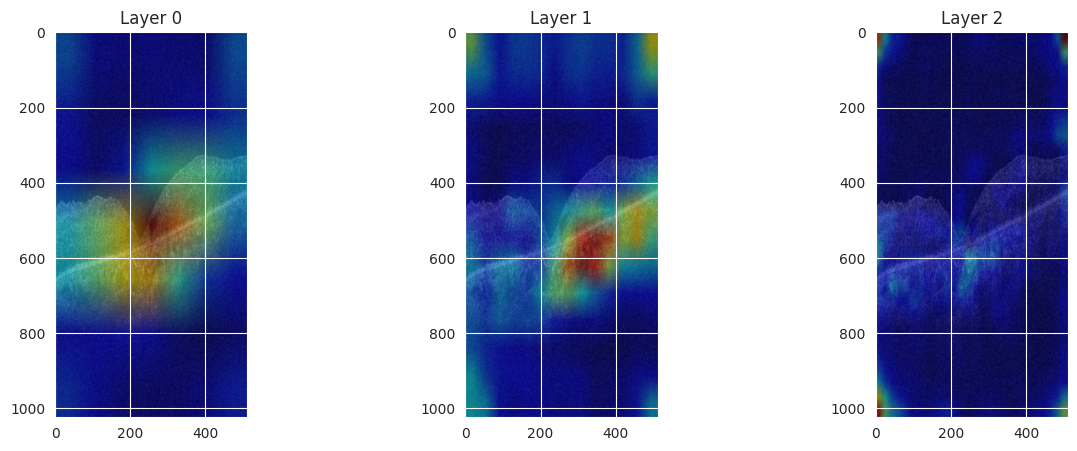

In [14]:
# Generate CAM for a specific class (e.g., class index 10)
target_class_index = None  # Automatically infer class if None
# Example: Experimenting with target layers in VGG16
target_layers = [
    model.features[-1],   # Last convolutional layer
    model.features[24],   # Intermediate convolutional layer
    model.features[17]    # Earlier convolutional layer
]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
original_image = Image.open(image_path).convert('RGB')
for i, layer in enumerate(target_layers):
    plt.subplot(1, 3, i+1)
    print(f"Testing target layer {i}: {layer}")
    gradcampp = GradCAMpp(model, target_layer=layer)
    cam = gradcampp.generate_cam(input_tensor, target_class=target_class_index)
    heatmap, blended_image = visualize_cam(cam, original_image)
    plt.imshow(blended_image)
    plt.title(f"Layer {i}")
plt.show()
# cam = gradcampp.generate_cam(input_tensor=input_tensor, target_class=target_class_index)
#
# # Visualize the CAM overlayed on the original image
# heatmap, overlayed_image = visualize_cam(cam, original_image)
#
# # Display results using Matplotlib
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 3, 1)
# plt.title("Original Image")
# plt.imshow(original_image)
# plt.axis('off')
#
# plt.subplot(1, 3, 2)
# plt.title("GradCAM++ Heatmap")
# plt.imshow(heatmap)
# plt.axis('off')
#
# plt.subplot(1, 3, 3)
# plt.title("Overlayed Image")
# plt.imshow(overlayed_image)
# plt.axis('off')
#
# plt.tight_layout()
# plt.show()
